In [1]:
import cv2
import time
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Process
from pathlib import Path
import faiss
from vit.main import main as ret_vit

## Input : Image Path

In [ ]:
### Out hyperparameter ###
result_path = '/home/Signboard_Retrieval/roadview_384_crop/match_score/'
topk = 1
match_weight = 1/4
method='vit'

### default ###

#all
device='cuda'

#vit
batch_size=64
num_workers=0
#########################

### 1. Crop : crop_get
    - Input:
        1. Input_1: Query 파노라마 이미지 경로
        2. Input_2: DB 파노라마 이미지 경로
        3. Input_3: Query 파노라마 이미지 간판 검출 결과(class, x,y,w,h) json 경로
        4. Input_4: DB 파노라마 이미지 간판 검출 결과(class, x,y,w,h) json 경로
        
        ======
        q_panorama = img path
        db_panorama = img path
        q_coord_list = json
        db_coord_list = json

In [73]:
def crop_get(q_img_path, db_img_path, q_json_path, db_json_path):
    
    '''
    q_img_path : str, query panorama image path
    db_img_path : str, db panorama image path
    q_json_path : str, query detetion result json path
    db_json_path : str, db detetion result json path
    '''
    
    panorama_id = Path(q_json_path).stem.split('@')[0] #str
    
    q_panorama = cv2.cvtColor(cv2.imread(q_img_path), cv2.COLOR_BGR2RGB)
    
    #get query cropped image
    q_crop_list = [] #많아봤자 10개 이미지, 작은 크기이므로
    with open(q_json_path, "r") as js:
        lbl = json.load(js)

        #read label
        for i in range(len(lbl['shapes'])):

            # crop image
            coord_list = lbl['shapes'][i]['points']
            x_list = list(map(lambda x: int(x[0]), coord_list))
            y_list = list(map(lambda x: int(x[1]), coord_list))
            del coord_list

            min_x = min(x_list)
            max_x = max(x_list)
            del x_list

            min_y = min(y_list)
            max_y = max(y_list)
            del y_list

            croppedImage = q_panorama[min_y: max_y, min_x: max_x]

            #get cropped Image
            q_crop_list.append(croppedImage)
            del croppedImage
        
    db_panorama = cv2.cvtColor(cv2.imread(db_img_path), cv2.COLOR_BGR2RGB)
        
    #get db cropped image
    db_crop_list = [] #많아봤자 10개 이미지, 작은 크기이므로
    with open(db_json_path, "r") as js:
        lbl = json.load(js)

        #read label
        for i in range(len(lbl['shapes'])):

            # crop image
            coord_list = lbl['shapes'][i]['points']
            x_list = list(map(lambda x: int(x[0]), coord_list))
            y_list = list(map(lambda x: int(x[1]), coord_list))
            del coord_list

            min_x = min(x_list)
            max_x = max(x_list)
            del x_list

            min_y = min(y_list)
            max_y = max(y_list)
            del y_list
            
            croppedImage = db_panorama[min_y: max_y, min_x: max_x]
            
            #get cropped Image
            db_crop_list.append(croppedImage)
            del croppedImage
        
    return q_crop_list, db_crop_list, panorama_id

In [74]:
#### sample #####

q_img_path = "/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_ori/query/960@21401901109_E.jpg"
db_img_path = "/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_ori/db/960@19642302437_E.jpg"

q_json_path = "/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_ori/query/960@21401901109_E.json"
db_json_path = "/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_ori/db/960@19642302437_E.json"


q_crop_list, db_crop_list, panorama_id = crop_get(q_img_path, db_img_path, q_json_path, db_json_path)

len(q_crop_list), len(db_crop_list), panorama_id

(7, 4, '960')

### 2. Feature Descriptor
    1. Only RootSIFT

In [4]:
# RootSIFT
# import the necessary packages

class RootSIFT:
	def __init__(self, max_kps):
		# initialize the SIFT feature extractor
		self.max_kps = max_kps
		self.extractor = cv2.SIFT_create(self.max_kps)
	def compute(self, image, kps, eps=1e-7):
		# compute SIFT descriptors
		kps, descs = self.extractor.detectAndCompute(image,kps)
		# if there are no keypoints or descriptors, return an empty tuple
		if len(kps) == 0:
			return ([], None)
		# apply the Hellinger kernel by first L1-normalizing and taking the
		# square-root(L2-noramlized)
		descs /= (descs.sum(axis=1, keepdims=True) + eps)
		descs = np.sqrt(descs)
		#descs /= (np.linalg.norm(descs, axis=1, ord=2) + eps)
# return a tuple of the keypoints and descriptors
		return (kps, descs)

In [5]:
# RootSIFT
def rootsift_extractor(img):
    '''
    Description: extract \emph{sift} feature from given image
    Input: file_path - image path
    Output: des - a list of descriptors of all the keypoint from the image
    '''
    gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rs = RootSIFT(99999) #full
    _, des = rs.compute(gray, None) 

    return des

### - utils
    1. k-means clustering
    2. get vlad vector
    3. L2 distance(numpy)

In [6]:
def get_cluster_center(des_set, K):
    '''
    Description: cluter using a default setting
    Input: des_set - cluster data
                 K - the number of cluster center
    Output: laber  - a np array of the nearest center for each cluster data
            center - a np array of the K cluster center
    '''
    des_set = np.float32(des_set) # for kmeans 
    
##########################[CPU-SLOW OPENCV KMEANS]##########################
    # criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.01)
    
    # ret, label, center = cv2.kmeans(des_set, K, None, criteria, 3, cv2.KMEANS_RANDOM_CENTERS)
#########################################################################

##########################[GPU-FAST FAISS KMEANS]##########################
    # Setup
    kmeans = faiss.Kmeans(d=128, k=K, niter=20, verbose=True, gpu=True)
    
    # Run clustering
    kmeans.train(des_set)
    
    # Centroids after clustering
    center = kmeans.centroids
    
    # The assignment for each vector.
    _, label = kmeans.index.search(des_set, 1)  # Need to run NN search again
    
    return label, center

In [7]:
# input : image
def get_des_vector(image_list, DESDIM=128):
    '''
    Description: get descriptors of all the images 
    Input: file_path_list - all images path
           DESDIM - SIFT local descriptor dimension 128
    Output:       all_des - a np array of all descriptors
            image_des_len - a list of number of the keypoints for each image 
    '''
    
    # all_des = np.empty(shape=[0, DESDIM]) #float64
    all_des = np.float32([]).reshape(0,DESDIM) #float32
    image_des_len = []

    for img in image_list:
        try:
            des = rootsift_extractor(img) # RootSIFT             
            all_des = np.concatenate([all_des, des]) #모든 이미지의 des vector를 concat 해서 출력! #np.concat : 다차원 배열의 결과
            image_des_len.append(len(des)) #각각 이미지의 len(des)을 따로 list에 모아두기.
        except:
            print("extract feature error")
    
    # feature num count
    featCnt = all_des.shape[0] #kp 개수
    print(str(featCnt) + " features in " + " images")
    
    return all_des, image_des_len, featCnt

In [8]:
def get_codebook(all_des, K):
    '''
    Description: train the codebook from all of the descriptors
    Input: all_des - training data for the codebook
                 K - the column of the codebook
    '''
    label, center = get_cluster_center(all_des, K)
    return label, center #center -> codebook

In [9]:
def get_vlad_base(img_des_len, NNlabel, all_des, codebook, COLUMNOFCODEBOOK, DESDIM=128):
    '''
    Description: get all images vlad vector 
    '''
    cursor = 0
    vlad_base = []
    for i, eachImage in enumerate(img_des_len):
        
        descrips = all_des[cursor : cursor + eachImage]
        centriods_id = NNlabel[cursor : cursor + eachImage]
        centriods = codebook[centriods_id]
    
        vlad = np.zeros(shape=[COLUMNOFCODEBOOK, DESDIM]).astype(np.float32) # VLAD vector: K * D 차원
        for eachDes in range(eachImage):
            vlad[centriods_id[eachDes]] = vlad[centriods_id[eachDes]] + descrips[eachDes] - centriods[eachDes] #차원 별 각각 중심으로부터 거리 (lacal feature 값 - NN 중심 값)
        cursor += eachImage # cursor 이동
    
        vlad_norm = vlad.copy()
        cv2.normalize(vlad, vlad_norm, 1.0, 0.0, cv2.NORM_L2) # 0에서 1사이로 L2 Norm
        vlad_base.append(vlad_norm.reshape(COLUMNOFCODEBOOK * DESDIM, -1)) # vlad_norm : 이미지 1장 -> vlad_base : DB 모든 이미지 M장 = (K*D)*M
    
    return vlad_base #VLAD Base Vector

In [10]:
def cal_vec_dist(vec1, vec2):
    '''
    Description: calculate the Euclidean Distance of two vectors (norm_l2)
    '''
    return np.linalg.norm(vec1 - vec2)

# query에 대해서 ON_LINE에서 진행되는 과정
def get_pic_vlad(pic, des_size, codebook, COLUMNOFCODEBOOK, DESDIM=128): # query의 vlad vector 만들기 by db의 codebook으로!
    '''
    Description: get the vlad vector of each image
    '''
    vlad = np.zeros(shape=[COLUMNOFCODEBOOK, DESDIM])
    for eachDes in range(des_size):
        des = pic[eachDes]
        min_dist = 1000000000.0
        ind = 0
        for i in range(COLUMNOFCODEBOOK):
            dist = cal_vec_dist(des, codebook[i]) # 각각 local feature가 중심으로부터 떨어진 거리
            if dist < min_dist: # 최근접 중심
                min_dist = dist
                ind = i
        vlad[ind] = vlad[ind] + des - codebook[ind] # 최근접 중심 + 떨어진 거리 : Vlad 정의
    
    vlad_norm = vlad.copy()
    cv2.normalize(vlad, vlad_norm, 1.0, 0.0, cv2.NORM_L2) #L2 Norm
    vlad_norm = vlad_norm.reshape(COLUMNOFCODEBOOK * DESDIM, -1)
    
    return vlad_norm

### 3.  Retrieval : ret_vlad (+get_db)
    - In online, we make db feat
    - SIFT Descriptor & VLAD feature aggregation
    - faiss, Cosine Similarity Matching

In [11]:
# input : image

def ret_vlad(q_crop_list, db_crop_list, panorama_id, result_path, metric="cs", device='cpu', DESDIM=128):
    
    '''
    panorama_id : ID of panorama, specific location identified number including query and database
    metric : str, how to compare with vectors, ["l2", "cs"], l2 is Euclidean Distance, cs is Cosine Similarity
    device : str, if 'cpu', faiss search with cpu else, 'gpu' or 'cuda', anything.
    '''
    
    ##get all the descriptor vectors of the data set
    print("db_feature_num")
    all_des, image_des_len, _ = get_des_vector(db_crop_list)

    ##get all the descriptor vectors of the query set
    print("q_feature_num")
    ret_des, ret_des_len, featCnt = get_des_vector(q_crop_list)
    
    #Code book size auto setting
    COLUMNOFCODEBOOK = int(featCnt / 39) #39, faiss recommendation

    ##trainning the codebook
    NNlabel, codebook = get_codebook(all_des, COLUMNOFCODEBOOK) #DB 사이즈에 따라 CD 크기가 바뀌므로, 매번 뽑아줘야 한다.
    
    #get all vlad vectors of the db set
    vlad_base = get_vlad_base(image_des_len, NNlabel, all_des, codebook, COLUMNOFCODEBOOK)
    del all_des #save memory
    
    db_num = len(image_des_len)
    del image_des_len #save memory

    ##get all the vlad vectors of retrival set without pca dimensionality reduction
    cursor_ret = 0
    ret_vlad_list = []
    for i, eachretpic in enumerate(range(len(ret_des_len))): #각각 이미지 des 길이들 만큼만 pick! -> 이미지 1장 1장에 대해 retrieval 해야 하므로!
        pic = ret_des[cursor_ret: cursor_ret + ret_des_len[eachretpic]]
        ret_vlad = get_pic_vlad(pic, ret_des_len[eachretpic], codebook, COLUMNOFCODEBOOK) # COLUMNOFCODEBOOK #CD
        cursor_ret += ret_des_len[eachretpic] # next cursor
        ret_vlad_list.append(ret_vlad)
    del ret_des, ret_des_len #save memory

    ### for faiss ###
    ### kernel died because of doulbing memory by copying it
    vlad_base = np.array(vlad_base).reshape(len(vlad_base), -1) #(개수, 차원) ex) K=5500 (3369, 704000)
    vlad_base = vlad_base.astype(np.float32)
    
    ret_vlad_set = np.array(ret_vlad_list).reshape(len(ret_vlad_list), -1) #(개수, 차원) ex) K=5500, (100, 704,000)
    ret_vlad_set = ret_vlad_set.astype(np.float32)
    
    ## faiss similarity search ##
    faiss.normalize_L2(vlad_base) # 자신의 절댓값 크기(sqrt(self**2))로 나눠준다.
    faiss.normalize_L2(ret_vlad_set)
    
    dim = COLUMNOFCODEBOOK * DESDIM # vlad_dim: K*D
    if metric == "l2":  # Norm L2 Dist
        cpu_index = faiss.IndexFlatL2(dim)
        
    else : # metric == "cs", cosine similarity
        cpu_index = faiss.IndexFlatIP(dim)
        
    if device == 'cpu':
        cpu_index.add(vlad_base)
        del vlad_base #save memory

        D, I = cpu_index.search(ret_vlad_set, cpu_index.ntotal) # 전체 쿼리(병렬) 몇 등까지 볼거야? 전체 다!
        
    else: #'cuda', 'gpu'
        
        #Clone from CPU to GPU
        co = faiss.GpuMultipleClonerOptions()
        co.shard = True
        co.useFloat16 = True
        index = faiss.index_cpu_to_all_gpus(cpu_index, co=co) # build the index
        index.add(vlad_base)
        del vlad_base #save memory
        
        D, I = index.search(ret_vlad_set, index.ntotal) # 전체 쿼리(병렬) 몇 등까지 볼거야? 전체 다!
    
    q_num = ret_vlad_set.shape[0]
    del ret_vlad_set #save memory
    
    #out result dic
    result_dic = {}
    
    for q_idx in range(q_num): # query index
        eval_list = []
        for db_idx in range(db_num): # db index
            eval_list.append((I[q_idx,db_idx], D[q_idx,db_idx]))
        result_dic[q_idx] = eval_list

    # save top1 pair .txt
    os.makedirs(result_path + '/sift_best_pair/', exist_ok=True)
    out_file = result_path + '/sift_best_pair/' + f"pair_{panorama_id}_sift" + ".txt"
    f_out = open(out_file, 'w')

    for q_idx in list(result_dic.keys()):
        #### L2 Distance/ Cos_Sim ####
        if metric == "l2":  # Norm L2 Dist
            rank_list = sorted(result_dic[q_idx], key = lambda x: x[1]) # Norm l2 dist
        else : # cosine similarity
            rank_list = sorted(result_dic[q_idx], key = lambda x: -x[1]) #cos sim
        ##############################
        for (db_idx, score)  in rank_list:
            f_out.write(str(q_idx) + '.jpg,' + str(db_idx) + '.jpg,' + str(score) + '\n')
            f_out.flush()
    f_out.close()
    #done
    print(f"\nSaving...\n{out_file}\nDone.")

In [14]:
### exec ###

start = time.perf_counter()

ret_vlad(q_crop_list, db_crop_list, panorama_id, result_path, metric="cs", device=device)
        
print("sift_ret_time", time.perf_counter()-start)

#time
#sift_ret_time 0.6549019259400666

db_feature_num
211 features in  images
q_feature_num
282 features in  images


WARNING clustering 211 points to 7 centroids: please provide at least 273 training points



Clustering 211 points in 128D to 7 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
  Iteration 19 (0.03 s, search 0.00 s): objective=56.3456 imbalance=1.050 nsplit=0       
Saving...
/home/Signboard_Retrieval/roadview_384_crop/match_score//sift_best_pair/pair_960_sift.txt
Done.
sift_ret_time 0.6785750221461058


### 4.  Retrieval : ret_vit
    - In online, we make vit feat of db
    - VIT Global Feature
    - faiss, Cosine Similarity Matching

In [16]:
start = time.perf_counter()

ret_vit(q_crop_list=q_crop_list, db_crop_list=db_crop_list, panorama_id=panorama_id, result_path=f"{result_path}/vit_best_pair/", \
        batch_size=batch_size, num_workers=num_workers, device=device)

print("vit_ret_time", time.perf_counter()-start)

#time
# vit_ret_time 4.403364397119731

extracting: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80batch/s]


feat shape is torch.Size([7, 144, 1536])
7
feature extraction: 0.36 sec
feature shape is (7, 144, 1536)
new_feature shape is (7, 221184)
convert to numpy: 0.00 sec
convert to tensor: 0.00 sec
===== Done: query_feature




extracting: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91batch/s]

feat shape is torch.Size([4, 144, 1536])
4
feature extraction: 0.26 sec
feature shape is (4, 144, 1536)
new_feature shape is (4, 221184)
convert to numpy: 0.00 sec
convert to tensor: 0.00 sec
===== Done: db_feature



Saving...
/home/Signboard_Retrieval/roadview_384_crop/match_score//vit_best_pair/pair_960_vit.txt
Done.
vit_ret_time 4.403364397119731


### 5. Multiprocessing : retrieval
    - SIFT_VLAD
    - VIT

In [14]:
# Multi-processing SIFT with VIT

device = 'cuda'

start = time.perf_counter()

proc1 = Process(target=ret_vlad, args=(q_crop_list, db_crop_list, panorama_id, "cs", device))
proc2 = Process(target=ret_vit, args=(q_crop_list, db_crop_list, panorama_id, f"{result_path}/vit_best_pair/", batch_size,\
                                     num_workers, device))
proc1.start(); proc1.join()
proc2.start(); proc2.join()

print("ret_time", time.perf_counter()-start)

#time
# ret_time 9.070821137167513 --> SLOW?!?!?

db_feature_num
211 features in  images
q_feature_num
282 features in  images


WARNING clustering 211 points to 7 centroids: please provide at least 273 training points


Clustering 211 points in 128D to 7 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
  Iteration 19 (0.01 s, search 0.00 s): objective=56.3456 imbalance=1.050 nsplit=0       
Saving...
/home/Signboard_Retrieval/roadview_384_crop/match_score//sift_best_pair/pair_960_sift.txt
Done.


/opt/conda/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
extracting:   0%|                                                                              | 0/1 [00:00<?, ?batch/s]

feat shape is torch.Size([7, 144, 1536])


extracting: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/batch]


7
feature extraction: 2.43 sec
feature shape is (7, 144, 1536)
new_feature shape is (7, 221184)
convert to numpy: 0.00 sec
convert to tensor: 0.00 sec
===== Done: query_feature




extracting:   0%|                                                                              | 0/1 [00:00<?, ?batch/s]

feat shape is torch.Size([4, 144, 1536])


extracting: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83batch/s]


4
feature extraction: 0.26 sec
feature shape is (4, 144, 1536)
new_feature shape is (4, 221184)
convert to numpy: 0.00 sec
convert to tensor: 0.00 sec
===== Done: db_feature



Saving...
/home/Signboard_Retrieval/roadview_384_crop/match_score//vit_best_pair/pair_960_vit.txt
Done.
ret_time 9.070821137167513


### 6. Merge : merge_topk
    - Merge SIFT& VIT 
        1. Cosine-Similarity Matching Score
    - Sort& Filter by topk

In [38]:
#input : path
def merge_topk(result_path, panorama_id, topk, match_weight, method='vit', algo='max'):
    
    '''
    topk: int, the number of matching candidates
    match_weight: float, threshold of whether matched or not
    result_path: str, folder path saving results, './match_score/'
    method: str, what you want to use, ['vit', 'sift', 'vit_sift', 'sift_vit']
    algo: str, matching algorithm, ['max', 'erase']
        - 'max' : matching pairs for maximizing score
        - 'erase' : matching pairs removing top1 prediction sequentially.
    '''
    
    #merge
    merge_dict = {}
        
    for m in method.split('_'):
        try:
            with open(f"{result_path}/{m}_best_pair/pair_{panorama_id}_{m}.txt", "r") as f:
                for line in f.readlines():
                    data = line.strip().split(',')
                    img1 = data[0].split('.')[0]
                    img2 = data[1].split('.')[0]
                    score = float(data[2]) #cosine_similarity

                    if img1+'-'+img2 not in merge_dict: #3가지 방법에서 특정 q_db pair가 중복된다면, 점수를 합산!
                        merge_dict[img1+'-'+img2] = score
                    else:
                        merge_dict[img1+'-'+img2] += score
        except:
            print(f"method {m} error")
    
    #change form
    result_dict = {}
    
    for key in merge_dict:
        imgs = key.split('-')
        q = imgs[0]
        db = imgs[1]
        del imgs
        score = merge_dict[key]
        
        #특정 query에 대해, 모든 ref를 list에 모아주기
        if q not in result_dict: #이 query가 처음 나왔을 때
            result_dict[q] = [(db, score)]
        else: #query가 중복될 경우
            db_list = result_dict[q]
            db_list.append((db, score))
            result_dict[q] = db_list

    #Matching Algorithm
    if algo == 'max':
    
        result_topk = {}

        for q in result_dict.keys():

            #use match score sorted
            topk_list = sorted(result_dict[q], key=lambda x: -x[1])[:topk] #(db, score)
            result_topk[q] = topk_list
            
    else: #algo == 'erase'
        result_topk = {}
        erase_list = []

        for q in result_dict.keys():

            #erase top1 matching
            erased_list = [(db, score) for (db, score) in result_dict[q] if db not in erase_list]

            if len(erased_list) != 0: #not empty
                #use match score sorted
                topk_list = sorted(erased_list, key=lambda x: -x[1])[:topk] #(db, score)
                result_topk[q] = topk_list

                #add erased top1 matched db, not score
                erase_list.append(topk_list[0][0])
            else: #empty -> score maximization
                topk_list = sorted(result_dict[q], key=lambda x: -x[1])[:topk] #(db, score)
                result_topk[q] = topk_list

    #match or not
    match_thres_dict = {'vit' : [0.34818036103100775, 0.18382692764634148], 'sift' : [0.24703212600804292, 0.14514607468375135], \
                        'vit_sift' : [0.5255381287510346, 0.28420164151355065], 'sift_vit' : [0.5255381287510346, 0.28420164151355065]}        
    
    # magic line for distinguish 'matched' from 'unmatched'
    match_thres = match_weight*match_thres_dict[method][0] + (1-match_weight)*match_thres_dict[method][1]

    # final result dict
    final_result_dict = {}
    
    final_dict = {}

    for q in result_topk.keys():
            
        thres_list = []

        for rank, (db, score) in enumerate(result_topk[q], start=1): #only db_name

            if score > match_thres: # positve : predict top 1 db

                thres_list.append(db)    
            else: # negative : predict empty list []
                pass
            
        final_dict[q] = thres_list
    
    final_result_dict[panorama_id] = final_dict
    
    #done
    print(f"\nMerge...\nresult_dict\nDone.")
    
    return final_result_dict

In [39]:
##### exec ######

start = time.perf_counter()

#merge_topk
result_dict = merge_topk(result_path, panorama_id, topk, match_weight, method='sift_vit')
print(result_dict)

print(f"merge_time: {time.perf_counter() - start}")

#time#
#erge_time: 0.006456070113927126

#result#
#<vit>
#{'960': {'0': ['1'], '1': ['0'], '2': ['1'], '3': ['3'], '4': ['2'], '5': ['3'], '6': ['3']}}

#<vit+sift>
#{'960': {'0': ['1'], '1': ['0'], '2': ['1'], '3': ['3'], '4': ['2'], '5': ['3'], '6': ['3']}}

#<sift>
#{'960': {'0': [], '1': ['0'], '2': ['0'], '3': ['1'], '4': ['2'], '5': ['3'], '6': []}}

{'960': {'0': ['1'], '1': ['0'], '2': ['1'], '3': ['3'], '4': ['2'], '5': ['3'], '6': ['3']}}
merge_time: 0.0018974149134010077


### - Visualization

In [82]:
# input image
# only for top1
def dic2visualization(q_img_path, db_img_path, q_json_path, db_json_path, result_dict,\
                      save_dir, method='vit'):
    
    panorama_id = Path(q_json_path).stem.split('@')[0] #str
    
    q_panorama = cv2.imread(q_img_path)
    
    db_panorama = cv2.imread(db_img_path)
    
    # horizontally concatenates images
    # of same height
    im_h = cv2.hconcat([q_panorama, db_panorama])
    
    # horizontal length
    h = q_panorama.shape[1]
    
    with open(q_json_path, "r") as js:
        q_lbl = json.load(js)
        
    with open(db_json_path, "r") as js:
        db_lbl = json.load(js)
    
    for q_idx in result_dict[panorama_id].keys():
        
        coord_list = q_lbl['shapes'][int(q_idx)]['points']
        x_list = list(map(lambda x: int(x[0]), coord_list))
        y_list = list(map(lambda x: int(x[1]), coord_list))
        del coord_list

        qmin_x = min(x_list)
        qmax_x = max(x_list)
        del x_list

        qmin_y = min(y_list)
        qmax_y = max(y_list)
        del y_list
        
        #draw rectangle
        if len(result_dict[panorama_id][q_idx]) == 0:#empty
            cv2.rectangle(im_h, (qmin_x,qmin_y), (qmax_x,qmax_y), (0,0,255), 2) #cv2 (B,G,R)
        else:
            cv2.rectangle(im_h, (qmin_x,qmin_y), (qmax_x,qmax_y), (0,255,0), 2)
        
            for db_idx in result_dict[panorama_id][q_idx]:

                coord_list = db_lbl['shapes'][int(db_idx)]['points']
                x_list = list(map(lambda x: int(x[0]), coord_list))
                y_list = list(map(lambda x: int(x[1]), coord_list))
                del coord_list

                dbmin_x = min(x_list)
                dbmax_x = max(x_list)
                del x_list

                dbmin_y = min(y_list)
                dbmax_y = max(y_list)
                del y_list
                
                #draw_rectangle
                cv2.rectangle(im_h, (dbmin_x+h,dbmin_y), (dbmax_x+h,dbmax_y), (0,255,0), 2)
                
                #draw line
                cv2.line(im_h, (qmax_x, int((qmin_y+qmax_y)/2)), (dbmin_x+h, int((dbmin_y+dbmax_y)/2)), (0,255,0), 2)
    
    #save
    out_file = save_dir + f"/pair_{panorama_id}_{method}.jpg"
    cv2.imwrite(save_dir + f"/pair_{panorama_id}_{method}.jpg", im_h)
    
    #done
    print(f"\nSaving...\n{out_file}\nDone.")
    
#####exec ####
                
q_img_path = "/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_ori/query/960@21401901109_E.jpg"
db_img_path = "/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_ori/db/960@19642302437_E.jpg"

q_json_path = "/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_ori/query/960@21401901109_E.json"
db_json_path = "/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_ori/db/960@19642302437_E.json"

save_dir = '/home/Signboard_Retrieval/roadview_384_crop/match_score/visualization/'

dic2visualization(q_img_path, db_img_path, q_json_path, db_json_path, result_dict,\
                  save_dir, method='vit')

#### - Result Sample
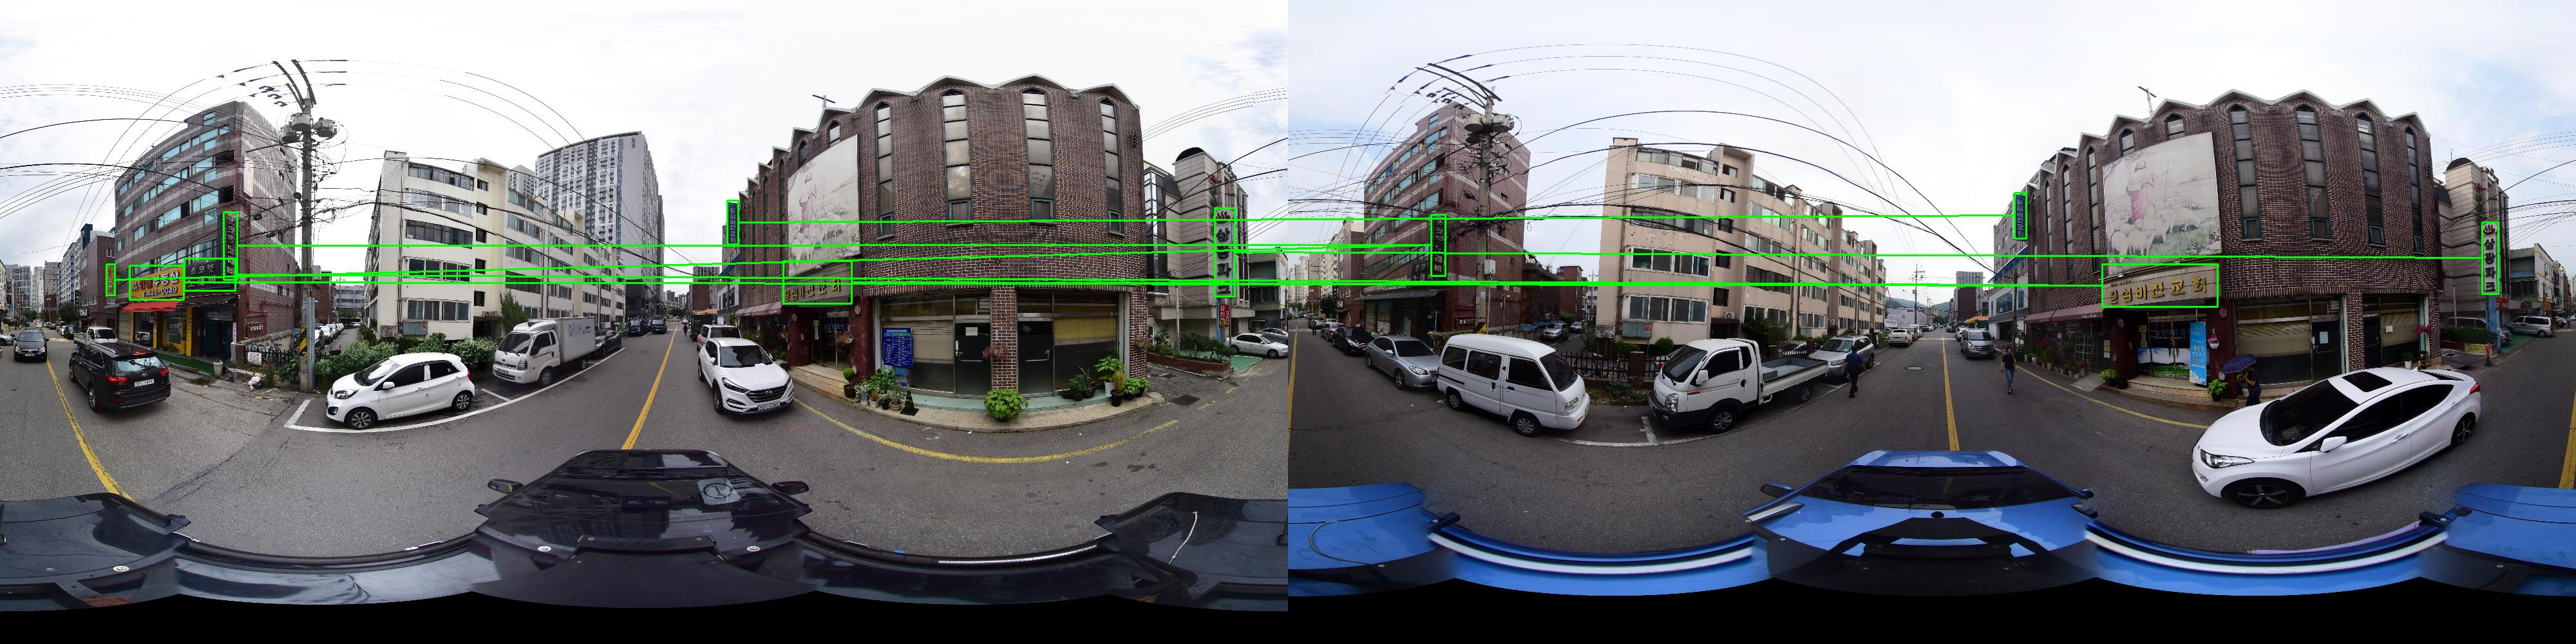